# HYPERPARAMETER TUNING

In [2]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter, CategoricalParameter

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [16]:
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.0001, 0.01),
    'batch_size': IntegerParameter(16, 128),
    'epochs': IntegerParameter(1, 3)
}

In [17]:
bucket_name = 'sagemaker-us-west-2-577585731673'
prefix = 'deep-learning/project/mobileNet'
estimator = PyTorch(
    entry_point='MobileNetTraining.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    framework_version='2.0.0',
    py_version='py310',
    output_path=f"s3://{bucket_name}/{prefix}/",
    checkpoint_s3_uri=f"s3://{bucket_name}/{prefix}/",
    code_location=f"s3://{bucket_name}/{prefix}/"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [18]:
s3_bucket = 'awsmlnn-dev'
s3_key = 'data/data_project.zip'
objective_metric_name = 'validation:f1_score'
metric_definitions = [
    {'Name': 'validation:accuracy', 'Regex': 'Validation Accuracy: ([0-9\\.]+)%'},
    {'Name': 'validation:f1_score', 'Regex': 'Validation F1-Score \\(weighted\\): ([0-9\\.]+)'}
]

In [19]:
# Create the HyperparameterTuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=3,
    objective_type='Maximize'
)

In [20]:
tuner.fit({'train': f's3://{s3_bucket}/{s3_key}'})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [22]:
# Get the best hyperparameters
best_training_job = tuner.best_training_job()
best_estimator = PyTorch.attach(best_training_job)

# Print out the best hyperparameters
best_hyperparameters = best_estimator.hyperparameters()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml

2024-07-06 23:37:19 Starting - Found matching resource for reuse
2024-07-06 23:37:19 Downloading - Downloading the training image
2024-07-06 23:37:19 Training - Training image download completed. Training in progress.
2024-07-06 23:37:19 Uploading - Uploading generated training model
2024-07-06 23:37:19 Completed - Resource released due to keep alive period expiry


### HYPERPARAMETER TUNING RESULTS
![Hyperparameter tuning](img/HT.png)
![Hyperparameter tuning](img/HT2.png)

In [33]:
new_best_hyperparameters = {
    'batch_size': int(best_hyperparameters['batch_size']),
    'epochs': int(best_hyperparameters['epochs']),
    'lr': float(best_hyperparameters['lr'])
}

In [34]:
new_best_hyperparameters

{'batch_size': 128, 'epochs': 3, 'lr': 0.0025546374233166936}

In [27]:
estimator = PyTorch(
    entry_point='MobileNetTraining.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    framework_version='2.0.0',
    py_version='py310',
    hyperparameters= new_best_hyperparameters,
    output_path=f"s3://{bucket_name}/{prefix}/",
    checkpoint_s3_uri=f"s3://{bucket_name}/{prefix}/",
    code_location=f"s3://{bucket_name}/{prefix}/"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [28]:
# Start the training job
estimator.fit({'train': f's3://{s3_bucket}/{s3_key}'})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-07-06-23-52-21-108


Using provided s3_resource
2024-07-06 23:52:21 Starting - Starting the training job...
2024-07-06 23:52:35 Starting - Preparing the instances for training...
2024-07-06 23:53:00 Downloading - Downloading input data...
2024-07-06 23:53:30 Downloading - Downloading the training image......
2024-07-06 23:54:30 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-06 23:54:42,335 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-06 23:54:42,335 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-06 23:54:42,336 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-07-06 23:54:42,344 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-07-06 23:54:42,346 sagemaker_pytorch_container.training INF

In [294]:
from sagemaker.debugger import Rule, DebuggerHookConfig, ProfilerConfig, ProfilerRule, rule_configs, FrameworkProfile

debugging_rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.class_imbalance()),
    Rule.sagemaker(rule_configs.confusion()),
]

profiling_rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    #ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.CPUBottleneck()),
    ProfilerRule.sagemaker(rule_configs.IOBottleneck())
]

all_rules = debugging_rules + profiling_rules

# Profiler Configuration with adjusted intervals
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000  # Collect system metrics every second
)

In [338]:
new_best_hyperparameters = {'batch_size': 32,
 'epochs': 1,
 'lr': 0.0025546374233166936}

In [339]:
bucket_name = 'sagemaker-us-west-2-577585731673'
prefix = 'deep-learning/project/mobileNet'
s3_bucket = 'awsmlnn-dev'
s3_key = 'data/data_project.zip'

In [349]:
collection_configs = [
    CollectionConfig(
        name="training_losses",
        parameters={
            "include_regex": ".*Loss.*",
            "train.save_interval": "100"
        }
    ),
    CollectionConfig(
        name="evaluation_metrics",
        parameters={
            "include_regex": ".*(Loss|Accuracy|F1-Score).*",
            "eval.save_interval": "50"
        }
    )
]

hook_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

In [350]:
estimator = PyTorch(
    entry_point='MobileNetTrainingDebugProfile.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    framework_version='2.0.0',
    py_version='py310',
    rules=all_rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    hyperparameters= new_best_hyperparameters,
    output_path=f"s3://{bucket_name}/{prefix}/",
    checkpoint_s3_uri=f"s3://{bucket_name}/{prefix}/",
    code_location=f"s3://{bucket_name}/{prefix}/"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [351]:
estimator.fit({'train': f's3://{s3_bucket}/{s3_key}'},wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-07-08-05-05-23-291


Using provided s3_resource
2024-07-08 05:05:23 Starting - Starting the training job...
2024-07-08 05:05:50 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
ClassImbalance: InProgress
Confusion: InProgress
ProfilerReport: InProgress
CPUBottleneck: InProgress
IOBottleneck: InProgress
...
2024-07-08 05:06:21 Downloading - Downloading input data...
2024-07-08 05:06:50 Downloading - Downloading the training image......
2024-07-08 05:07:50 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-08 05:07:58,192 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-08 05:07:58,192 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-08 05:07:5

In [15]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [16]:
! aws s3 ls {rule_output_path} --recursive

2024-07-07 20:06:35     329696 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-07-07 20:06:34     171070 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-07-07 20:06:31        191 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-07-07 20:06:31        199 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-07-07 20:06:31        126 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-07-07 20:06:31        127 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/Profi

In [17]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler

In [18]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [111]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [46]:
#!pip install smdebug

In [352]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
tensor_names = trial.tensor_names()
print(tensor_names)

[2024-07-08 05:12:49.775 default:166 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-08-05-05-23-291/debug-output
['CrossEntropyLoss_input_0', 'CrossEntropyLoss_input_1', 'CrossEntropyLoss_output_0', 'gradient/MobileNetV3_model.classifier.3.bias', 'gradient/MobileNetV3_model.classifier.3.weight', 'labels', 'outputs', 'scalar/Validation Accuracy', 'scalar/Validation F1-Score']


In [353]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


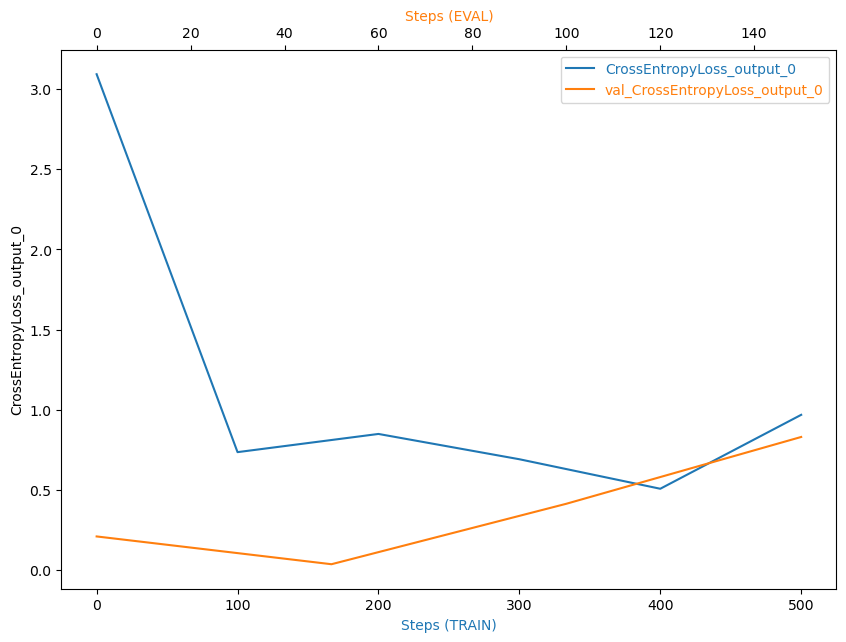

In [354]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

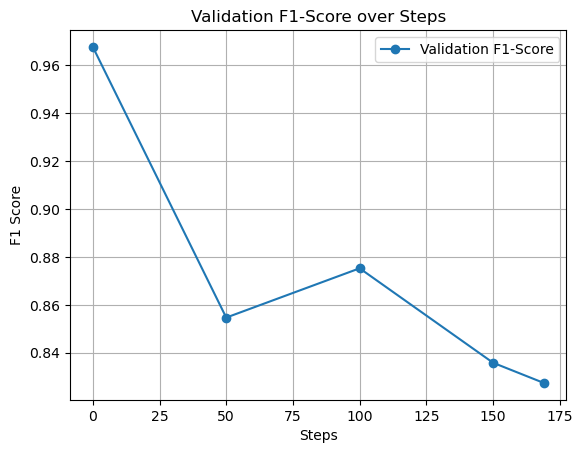

In [370]:
tensor_name = 'scalar/Validation F1-Score'
steps, vals = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
plt.plot(steps, vals, label='Validation F1-Score', marker='o')
plt.xlabel('Steps')
plt.ylabel('F1 Score')
plt.title('Validation F1-Score over Steps')
plt.legend()
plt.grid(True)
plt.show()